In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [12]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [13]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

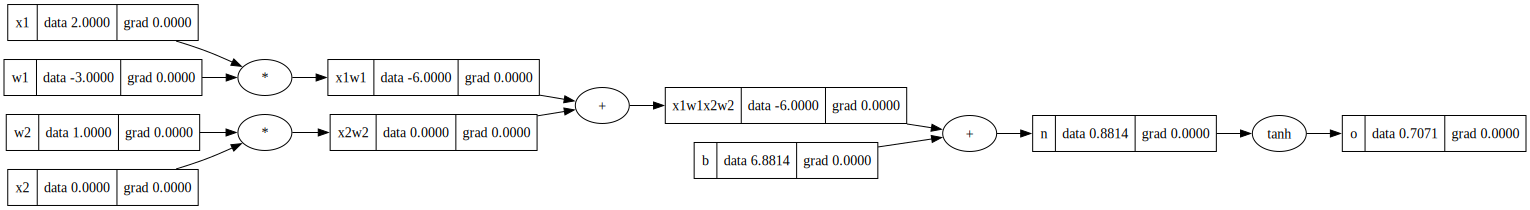

In [14]:
draw_dot(o)

In [15]:
o.backward()

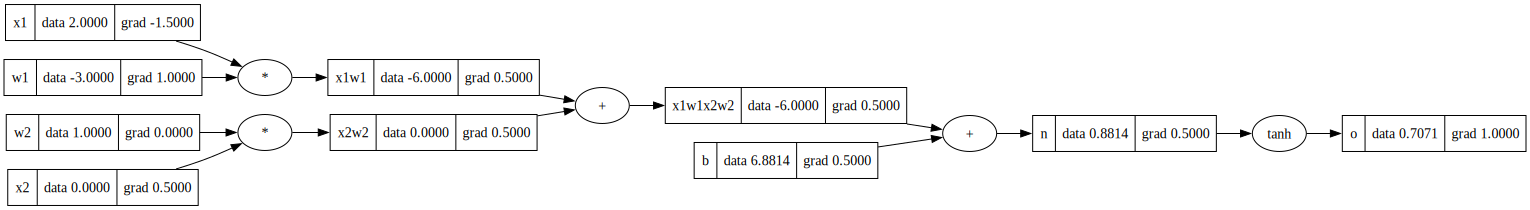

In [16]:
draw_dot(o)

Now we can breakdown tanh even more:

The hyperbolic tangent function is given by:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$


Also, we can't do something like

In [17]:
# a = Value(2.0)
# a + 1

# AttributeError: 'int' object has no attribute 'data'

This is because 1 is not a value

In [18]:
# we can do something like this

def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

#  similarly we can do this for __mul__
    

In [19]:
# Also we can do (a * 2) but not (2 * a)

# This is because python is doing a.__mul__(2) for (a * 2)

# and 2.__mul__(a) for (2 * a)

In [20]:
# we can add def __rmul__(self, other) to handle this
    #  return self * other
# Basically does other * self when fails to do self * other

Now in order to break tanh even more, we will need to implement how to exponentiate, how to divide and also how to subtract(which is basically adding the negative)

For division we can implement something even better

Basically

$$
\frac{a}{b} = a \cdot \frac{1}{b} = a \cdot b^{-1}
$$


That is we will implement power function

So let's implement everything we mentioned above

In [21]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float power for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): #other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other ** -1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [22]:
# a = Value(2.0)
# b = 3.0
# a / b

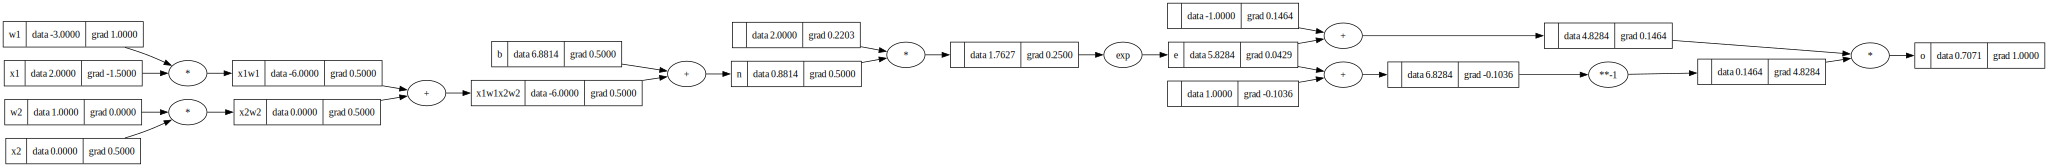

In [23]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# ----------------------------

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

So both forward and backward pass is working correctly!! 

Also the level at which we implement out operation is totally up to us, we can implement backward passes for tiny expressions like a single individual "+" or we can implement it for tanh

#### Now let's do the exact same thing using modern deep learning neural network library like PyTorch

So let's do the exact same thing but in PyTorch API

Micrograd is a scalar valued engine but we know in PyTorch, every thing is based around tensors which are basically a n-dimensional array of scalars

In [ ]:
import torch

In [24]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

# By default pytorch assumes leaf nodes donb't require grad, so we need to set requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Just like micrograd, it has data and grad attribute

# Since this returns a tensor, that's why we need to do item() to get the value
print(o.data.item())
o.backward()

print("-------------------")

print("x1 grad", x1.grad.item())
print("w1 grad", w1.grad.item())
print("x2 grad", x2.grad.item())
print("w2 grad", w2.grad.item())

NameError: name 'torch' is not defined

Big deal with Pytorch is everything is significantly more efficient because we are working with this tensor objects and we can do a lot of operations in parallel

#### Now let's start Building our Neural Net piece by piece, ultimately will build a two layer MLP